# Helpers

In [1]:
!python -m pip install ipympl
!python -m pip install seaborn

In [2]:
%matplotlib widget
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from itertools import chain
import scipy
import seaborn as sns
sns.set_theme(style="darkgrid")
from vw_executor.vw import Vw
from vw_executor.loggers import ConsoleLogger


def new_ax():
    _,ax = plt.subplots(dpi=100, figsize=[9,4])
    return ax        

def _predictions_parse(lines):
    for l in lines:
        if ':' in l:
            yield {int(kv.split(':')[0]): float(kv.split(':')[1]) for kv in l.split(',')}

def predictions_2_df(files):
    return pd.DataFrame(_predictions_parse(chain(*map(lambda f: open(f), files))))

def plot(sim, result, i):
    job = result.iloc[i]['!Job']
    prediction_files = job.outputs['-p']
    df = pd.concat([sim, predictions_2_df(prediction_files)], axis=1)
    [df[(df['shared_good']==i)][j].rolling(window=100).mean().plot(
        figsize=[16,6], label=f'P(chosen={j} | Person={i})') for i in [0,1] for j in [0,1]]
    plt.legend(loc='best')

class Simulation:
    def __init__(self, n=10000, swap_after=5000, variance = 0, bad = 0):
        self.examples = []
        offset = 0
        for i in range(1, n):
            if i % swap_after == 0:
                offset = (offset + 1) % 2

            person = i % 2 # random.randint(0, 1)
            chosen = i % 4  // 2 #random.randint(0, 1)
            if (chosen + person + offset) % 2 == 0:
                reward =  0.7 + ((chosen + offset) % 2) * 0.1#int(random.random() < 0.7 + ((chosen + offset) % 2) * 0.1)
            else:
                reward = 0.3 - ((chosen + offset + 1) % 2) * 0.1 #int(random.random() < 0.3 - ((chosen + offset + 1) % 2) * 0.1)

            reward = reward + scipy.random.normal(0, variance)

            self.examples.append({
                "reward": reward,
                "shared_good": person,
                "a1_good": '0',
                "a2_good": '1',
                "chosen": chosen, 
                "prob": 0.5
            })
            for i in range(bad):
                self.examples[-1][f'a1_bad_{i}'] = random.random()
                self.examples[-1][f'a2_bad_{i}'] = random.random()
        self.df = pd.DataFrame(self.examples)
    
    def get(self):
        return pd.DataFrame(self.examples)
    
    def to_dsjson(self):
        for row in self.examples:
            o = {
                "_label_cost": -row['reward'],
                "_label_probability": row['prob'],
                "_label_Action": int(row['chosen'] + 1),
                "_labelIndex": int(row['chosen']),
                "a": [row['chosen'] + 1, (row['chosen'] + 1) % 2 + 1],
                "c": {'shared': {'f': str(row['shared_good'])},
                    '_multi': [{'a': {'f': str(row['a1_good']), 'constant': 1}},
                        {'a': {'f': str(row['a2_good'])}}]},
                "p": [row['prob'], 1 - row['prob']] 
            }
            i = 0
            while True:
                if f'a1_bad_{i}' in row:
                    if 'b' not in o['c']['_multi'][0]: 
                        o['c']['_multi'][0]['b'] = {}
                        o['c']['_multi'][1]['b'] = {}   
                    o['c']['_multi'][0]['b'][f'a1_bad_{i}'] = row[f'a1_bad_{i}']
                    o['c']['_multi'][1]['b'][f'a2_bad_{i}'] = row[f'a1_bad_{i}']
                    i += 1
                else:
                    break
            yield json.dumps(o, separators=(",", ":"))

    def to_dsjson_file(self, fname):
        with open(fname, 'w') as f:
            for ex in self.to_dsjson():
                f.write(f'{ex}\n')             

    def visualize(self, window=100, ax = None):
        colors = ['green', 'red']
        styles = ['-', '-.']
        if ax is None:
            ax = (new_ax(), new_ax())
        [self.df[(self.df['shared_good']==i) & (self.df['chosen']==j)].rolling(window=window)['reward'].mean().plot(
            ax=ax[0], color = colors[j], style=styles[i], label=f'Person: {i}, chosen: {j}') for i in [0,1] for j in [0,1]]
        [self.df[self.df['chosen']==j].rolling(window=window)['reward'].mean().plot(
            ax=ax[1], color = colors[j], label=f'Chosen: {j}') for j in [0,1]]     
        ax[0].legend()
        ax[1].legend()
        
def _predictions_parse(lines):
    for l in lines:
        if ':' in l:
            yield {int(kv.split(':')[0]): float(kv.split(':')[1]) for kv in l.split(',')}

def predictions_2_df(files):
    return pd.DataFrame(_predictions_parse(chain(*map(lambda f: open(f), files))))

def plot(sim, result, i):
    colors = ['green', 'red']
    styles = ['-', '-.']
    job = result.iloc[i]['!Job']
    prediction_files = job.outputs['-p']
    df = pd.concat([sim, predictions_2_df(prediction_files)], axis=1)
    ax = new_ax()
    [df[(df['shared_good']==i)][j].rolling(window=100).mean().plot(
        ax=ax, color = colors[j], style=styles[i], label=f'P(chosen={j} | Person={i})') for i in [0,1] for j in [0,1]]
    ax.legend(loc='best')
    
def plot(sim, job, ax):
    colors = ['green', 'red']
    styles = ['-', '-.']
    prediction_files = job.outputs['-p']
    df = pd.concat([sim.get(), predictions_2_df(prediction_files)], axis=1)
    [(df[(df['shared_good']==i)][j].rolling(window=100).mean() + i * 0.05).plot(
        ax=ax, color = colors[j], style=styles[i], label=f'P(chosen={j} | Person={i})') for i in [0,1] for j in [0,1]]
    ax.legend(loc='best')
    
def generate_and_visualize(n=10000, swap_after=5000, variance=0, bad_log=0, window=100, ax=None, fig=None):
    sim = Simulation(n=n, swap_after=swap_after, variance = variance, bad = 2**bad_log)
    ax[0].clear()
    ax[1].clear()
    fig.suptitle('Data', fontsize=16)
    sim.visualize(window = window, ax=ax) 
    fig.canvas.draw_idle()
    
def generate_and_learn(n=10000, swap_after=5000, variance=0, bad_log=0, window=100, 
                       learning_rate=-20, coin=False, l1=-20, cb_type='ips', 
                       interactions='', ignore='', ignore_linear='', marginals='', ax=None, fig=None):
    sim = Simulation(n=n, swap_after=swap_after, variance = variance, bad = 2**bad_log)
    ax[0][0].clear()
    ax[0][1].clear()
    ax[1][0].clear()
    ax[1][1].clear()

    fig.suptitle('Data', fontsize=16)
    sim.to_dsjson_file('small.json')

    opts = {'#base': '--cb_explore_adf --dsjson --epsilon 0.2',
            '#0': interactions,
            '#1': ignore,
            '#2': ignore_linear,
            '#3': marginals,
            '#lr': '--coin' if coin else f'--power_t 0 --learning_rate {2**learning_rate}',
            '--l1': 2**l1,
            '--cb_type': cb_type
           }

    result = Vw('vw', '.vw_cache', handlers=[],
                loggers=[
     #              ConsoleLogger('DEBUG')
                ]).train(['small.json'], opts, ['-p'])
    
    sim.visualize(window = window, ax=ax[0]) 
    plot(sim, result, ax[1][0])
    fig.canvas.draw_idle()
    

# Look at the data

In [3]:
sim = Simulation(n=100, swap_after=50, variance = 0.1, bad = 2)
sim.get().head()

,reward,shared_good,a1_good,a2_good,chosen,prob,a1_bad_0,a2_bad_0,a1_bad_1,a2_bad_1
0,0.077477,1,0,1,0,0.5,0.324202,0.127455,0.566664,0.306330
1,0.317228,0,0,1,1,0.5,0.598731,0.397407,0.425541,0.403073
2,0.769646,1,0,1,1,0.5,0.407946,0.879084,0.487323,0.854860
3,0.734909,0,0,1,0,0.5,0.750402,0.366077,0.931647,0.034564
4,0.146743,1,0,1,0,0.5,0.161590,0.869794,0.368259,0.079667


In [9]:
json.loads(next(Simulation(n=10000, swap_after=5000, variance = 0, bad = 2).to_dsjson()))

{'_label_cost': -0.19999999999999998,
 '_label_probability': 0.5,
 '_label_Action': 1,
 '_labelIndex': 0,
 'a': [1, 2],
 'c': {'shared': {'f': '1'},
  '_multi': [{'a': {'f': '0', 'constant': 1},
    'b': {'a1_bad_0': 0.0359312221429785, 'a1_bad_1': 0.3371683737873694}},
   {'a': {'f': '1'},
    'b': {'a2_bad_0': 0.0359312221429785, 'a2_bad_1': 0.3371683737873694}}]},
 'p': [0.5, 0.5]}

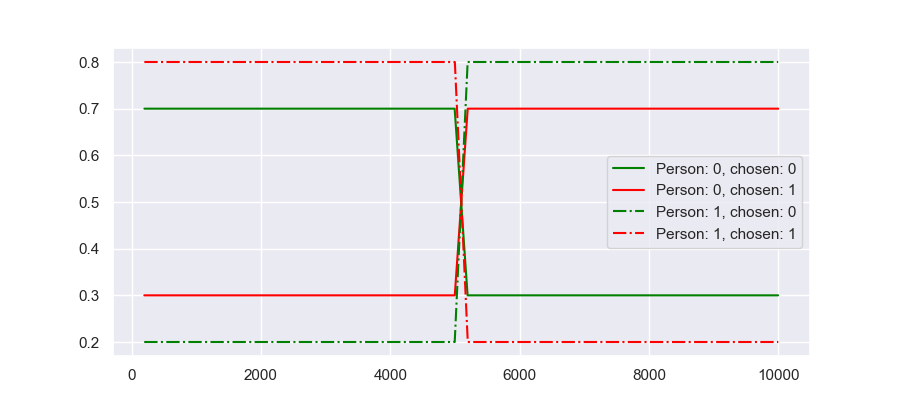

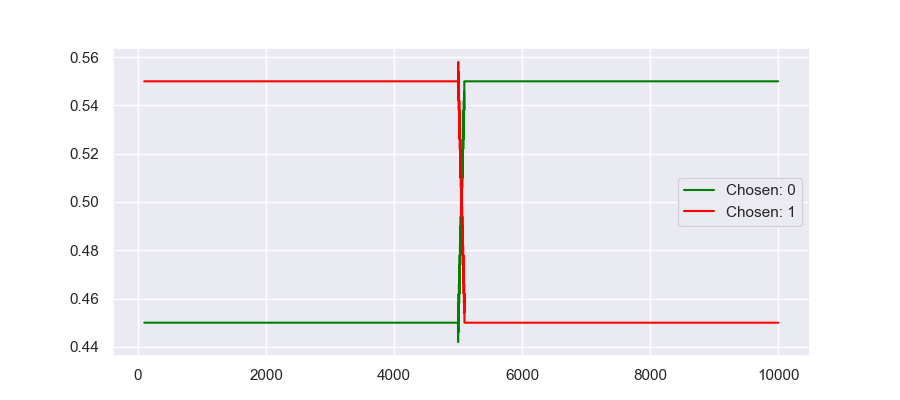

In [4]:
Simulation(n=10000, swap_after=5000, variance = 0, bad = 2).visualize(window=50)

# Interact

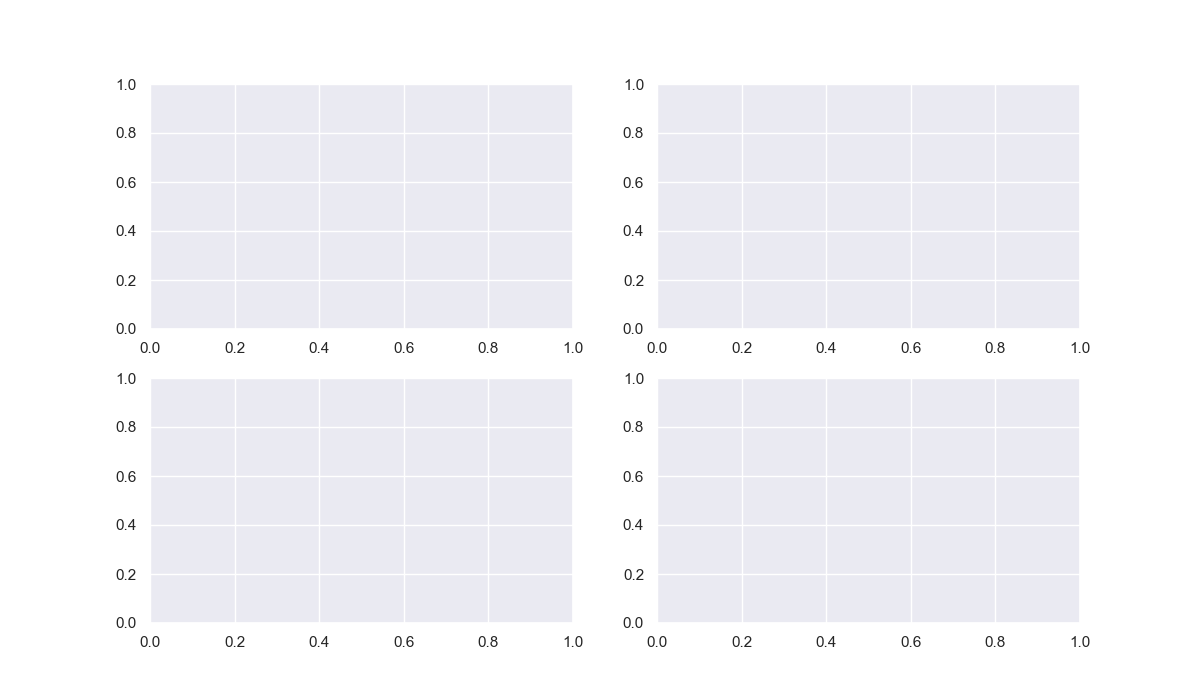

In [6]:
from ipywidgets import *

fig, ax = plt.subplots(2, 2, figsize=(12,7))

widget = interactive(
    generate_and_learn,
    n=IntSlider(min=1000, max=20000, step=1000, value=10000),
    swap_after=IntSlider(min=1000, max=20000, step=1000, value=5000),
    variance=FloatSlider(min=0, max=2, step=0.1, value=0),
    bad_log=IntSlider(min=0, max=10, step=1, value = 0),
    window=IntSlider(min=1, max=1000, step=10, value = 1),
    learning_rate=IntSlider(min=-20,max=10, step=1, value=-20),
    coin=Checkbox(),
    l1=IntSlider(min=-20,max=10, step=1, value=-20),
    cb_type=['ips', 'mtr'],
    interactions=['', '-q sa', '-q ab', '-q sb', '-q ::'],
    ignore=['', '--ignore b'],
    ignore_linear=['', '--ignore_linear sab'],
    marginals=['', '--marginal a'],
    ax=fixed(ax),
    fig=fixed(fig))

data_controls = HBox(widget.children[:4])
visualization_controls = HBox(widget.children[4:5])
learning_controls = HBox(widget.children[5:-5])
extra = HBox(widget.children[-5:-1])
output = widget.children[-1]
display(VBox([data_controls, visualization_controls, learning_controls, extra, output]))

In [28]:
import itertools
def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(itertools.combinations(s, r) for r in range(len(s)+1))

from vw_executor.vw import Vw
from vw_executor.vw_opts import product, dimension
import pandas as pd

vw = Vw('vw', '.vw_cache')

step1 = pd.DataFrame(product(
    dimension('#base', ['--cb_explore_adf -P 1000 --preserve_performance_counters --save_resume --dsjson --power_t 0']),
    dimension('--learning_rate', [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10]),
    dimension('--l1', [1e-9, 1e-6, 1e-3]),
    dimension('--cb_type', ['ips', 'mtr']),
    dimension('#marginal', ['', '--marginal a'])
    ))

step2 = pd.DataFrame(
    dimension('#interactions', [f'-q {" ".join([t[0] + t[1] for t in c])}'
                                for c in powerset((itertools.product(['s', 'a', 'b'], ['s', 'a', 'b'])))]))
inputs = ['small.json']


first_step_result = vw.train(inputs, step1)
second_step_result = vw.train(inputs, pd.DataFrame(product(first_step_result.sort_values('!Loss').head(1)), step2))
third_step_result = vw.train(inputs, pd.DataFrame(product(second_step_result.sort_values('!Loss').head(1)), step1))


Total:   0%|          | 0/96 [00:00<?, ?it/s]

 --cb_type ips --l1 1e-09 --learning_rate 1e-06:   0%|          | 0/1 [00:00<?, ?it/s]

 --cb_type ips --l1 1e-09 --learning_rate 1e-05:   0%|          | 0/1 [00:00<?, ?it/s]

 --cb_type mtr --l1 1e-06 --learning_rate 1e-06:   0%|          | 0/1 [00:00<?, ?it/s]

 --cb_type mtr --l1 1e-06 --learning_rate 1e-05:   0%|          | 0/1 [00:00<?, ?it/s]

--marginal a --cb_type ips --l1 1e-09 --learning_rate 1e-06:   0%|          | 0/1 [00:00<?, ?it/s]

--marginal a --cb_type ips --l1 1e-09 --learning_rate 1e-05:   0%|          | 0/1 [00:00<?, ?it/s]

--marginal a --cb_type mtr --l1 1e-06 --learning_rate 1e-06:   0%|          | 0/1 [00:00<?, ?it/s]

--marginal a --cb_type mtr --l1 1e-06 --learning_rate 1e-05:   0%|          | 0/1 [00:00<?, ?it/s]

 --cb_type ips --l1 0.001 --learning_rate 1e-06:   0%|          | 0/1 [00:00<?, ?it/s]

 --cb_type mtr --l1 1e-09 --learning_rate 1e-05:   0%|          | 0/1 [00:00<?, ?it/s]

 --cb_type mtr --l1 1e-09 --learning_rate 1e-06:   0%|          | 0/1 [00:00<?, ?it/s]

 --cb_type ips --l1 0.001 --learning_rate 1e-05:   0%|          | 0/1 [00:00<?, ?it/s]

--marginal a --cb_type mtr --l1 1e-09 --learning_rate 1e-05:   0%|          | 0/1 [00:00<?, ?it/s]

--marginal a --cb_type ips --l1 0.001 --learning_rate 1e-05:   0%|          | 0/1 [00:00<?, ?it/s]

--marginal a --cb_type ips --l1 0.001 --learning_rate 1e-06:   0%|          | 0/1 [00:00<?, ?it/s]

--marginal a --cb_type mtr --l1 1e-09 --learning_rate 1e-06:   0%|          | 0/1 [00:00<?, ?it/s]

 --cb_type mtr --l1 0.001 --learning_rate 1e-05:   0%|          | 0/1 [00:00<?, ?it/s]

 --cb_type ips --l1 1e-06 --learning_rate 1e-06:   0%|          | 0/1 [00:00<?, ?it/s]

 --cb_type mtr --l1 0.001 --learning_rate 1e-06:   0%|          | 0/1 [00:00<?, ?it/s]

 --cb_type ips --l1 1e-06 --learning_rate 1e-05:   0%|          | 0/1 [00:00<?, ?it/s]

--marginal a --cb_type ips --l1 1e-06 --learning_rate 1e-05:   0%|          | 0/1 [00:00<?, ?it/s]

--marginal a --cb_type mtr --l1 0.001 --learning_rate 1e-05:   0%|          | 0/1 [00:00<?, ?it/s]

--marginal a --cb_type ips --l1 1e-06 --learning_rate 1e-06:   0%|          | 0/1 [00:00<?, ?it/s]

--marginal a --cb_type mtr --l1 0.001 --learning_rate 1e-06:   0%|          | 0/1 [00:00<?, ?it/s]

 --cb_type mtr --l1 1e-06 --learning_rate 0.001:   0%|          | 0/1 [00:00<?, ?it/s]

 --cb_type mtr --l1 1e-06 --learning_rate 0.0001:   0%|          | 0/1 [00:00<?, ?it/s]

 --cb_type ips --l1 1e-09 --learning_rate 0.001:   0%|          | 0/1 [00:00<?, ?it/s]

 --cb_type ips --l1 1e-09 --learning_rate 0.0001:   0%|          | 0/1 [00:00<?, ?it/s]

--marginal a --cb_type ips --l1 1e-09 --learning_rate 0.0001:   0%|          | 0/1 [00:00<?, ?it/s]

--marginal a --cb_type ips --l1 1e-09 --learning_rate 0.001:   0%|          | 0/1 [00:00<?, ?it/s]

--marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.0001:   0%|          | 0/1 [00:00<?, ?it/s]

--marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.001:   0%|          | 0/1 [00:00<?, ?it/s]

 --cb_type ips --l1 0.001 --learning_rate 0.0001:   0%|          | 0/1 [00:00<?, ?it/s]

 --cb_type mtr --l1 1e-09 --learning_rate 0.001:   0%|          | 0/1 [00:00<?, ?it/s]

 --cb_type mtr --l1 1e-09 --learning_rate 0.0001:   0%|          | 0/1 [00:00<?, ?it/s]

 --cb_type ips --l1 0.001 --learning_rate 0.001:   0%|          | 0/1 [00:00<?, ?it/s]

--marginal a --cb_type mtr --l1 1e-09 --learning_rate 0.001:   0%|          | 0/1 [00:00<?, ?it/s]

--marginal a --cb_type ips --l1 0.001 --learning_rate 0.001:   0%|          | 0/1 [00:00<?, ?it/s]

--marginal a --cb_type mtr --l1 1e-09 --learning_rate 0.0001:   0%|          | 0/1 [00:00<?, ?it/s]

--marginal a --cb_type ips --l1 0.001 --learning_rate 0.0001:   0%|          | 0/1 [00:00<?, ?it/s]

 --cb_type mtr --l1 0.001 --learning_rate 0.001:   0%|          | 0/1 [00:00<?, ?it/s]

 --cb_type mtr --l1 0.001 --learning_rate 0.0001:   0%|          | 0/1 [00:00<?, ?it/s]

 --cb_type ips --l1 1e-06 --learning_rate 0.0001:   0%|          | 0/1 [00:00<?, ?it/s]

 --cb_type ips --l1 1e-06 --learning_rate 0.001:   0%|          | 0/1 [00:00<?, ?it/s]

--marginal a --cb_type mtr --l1 0.001 --learning_rate 0.001:   0%|          | 0/1 [00:00<?, ?it/s]

--marginal a --cb_type mtr --l1 0.001 --learning_rate 0.0001:   0%|          | 0/1 [00:00<?, ?it/s]

--marginal a --cb_type ips --l1 1e-06 --learning_rate 0.0001:   0%|          | 0/1 [00:00<?, ?it/s]

--marginal a --cb_type ips --l1 1e-06 --learning_rate 0.001:   0%|          | 0/1 [00:00<?, ?it/s]

 --cb_type mtr --l1 1e-06 --learning_rate 0.01:   0%|          | 0/1 [00:00<?, ?it/s]

 --cb_type ips --l1 1e-09 --learning_rate 0.01:   0%|          | 0/1 [00:00<?, ?it/s]

 --cb_type ips --l1 1e-09 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

 --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

--marginal a --cb_type ips --l1 1e-09 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

--marginal a --cb_type ips --l1 1e-09 --learning_rate 0.01:   0%|          | 0/1 [00:00<?, ?it/s]

--marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.01:   0%|          | 0/1 [00:00<?, ?it/s]

--marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

 --cb_type ips --l1 0.001 --learning_rate 0.01:   0%|          | 0/1 [00:00<?, ?it/s]

 --cb_type mtr --l1 1e-09 --learning_rate 0.01:   0%|          | 0/1 [00:00<?, ?it/s]

 --cb_type mtr --l1 1e-09 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

 --cb_type ips --l1 0.001 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

--marginal a --cb_type ips --l1 0.001 --learning_rate 0.01:   0%|          | 0/1 [00:00<?, ?it/s]

--marginal a --cb_type mtr --l1 1e-09 --learning_rate 0.01:   0%|          | 0/1 [00:00<?, ?it/s]

--marginal a --cb_type ips --l1 0.001 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

--marginal a --cb_type mtr --l1 1e-09 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

 --cb_type ips --l1 1e-06 --learning_rate 0.01:   0%|          | 0/1 [00:00<?, ?it/s]

 --cb_type mtr --l1 0.001 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

 --cb_type ips --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

 --cb_type mtr --l1 0.001 --learning_rate 0.01:   0%|          | 0/1 [00:00<?, ?it/s]

--marginal a --cb_type ips --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

--marginal a --cb_type ips --l1 1e-06 --learning_rate 0.01:   0%|          | 0/1 [00:00<?, ?it/s]

--marginal a --cb_type mtr --l1 0.001 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

--marginal a --cb_type mtr --l1 0.001 --learning_rate 0.01:   0%|          | 0/1 [00:00<?, ?it/s]

 --cb_type ips --l1 1e-09 --learning_rate 10.0:   0%|          | 0/1 [00:00<?, ?it/s]

 --cb_type mtr --l1 1e-06 --learning_rate 10.0:   0%|          | 0/1 [00:00<?, ?it/s]

 --cb_type ips --l1 1e-09 --learning_rate 1.0:   0%|          | 0/1 [00:00<?, ?it/s]

 --cb_type mtr --l1 1e-06 --learning_rate 1.0:   0%|          | 0/1 [00:00<?, ?it/s]

--marginal a --cb_type ips --l1 1e-09 --learning_rate 10.0:   0%|          | 0/1 [00:00<?, ?it/s]

--marginal a --cb_type ips --l1 1e-09 --learning_rate 1.0:   0%|          | 0/1 [00:00<?, ?it/s]

--marginal a --cb_type mtr --l1 1e-06 --learning_rate 1.0:   0%|          | 0/1 [00:00<?, ?it/s]

--marginal a --cb_type mtr --l1 1e-06 --learning_rate 10.0:   0%|          | 0/1 [00:00<?, ?it/s]

 --cb_type ips --l1 0.001 --learning_rate 1.0:   0%|          | 0/1 [00:00<?, ?it/s]

 --cb_type mtr --l1 1e-09 --learning_rate 10.0:   0%|          | 0/1 [00:00<?, ?it/s]

 --cb_type mtr --l1 1e-09 --learning_rate 1.0:   0%|          | 0/1 [00:00<?, ?it/s]

 --cb_type ips --l1 0.001 --learning_rate 10.0:   0%|          | 0/1 [00:00<?, ?it/s]

--marginal a --cb_type mtr --l1 1e-09 --learning_rate 10.0:   0%|          | 0/1 [00:00<?, ?it/s]

--marginal a --cb_type ips --l1 0.001 --learning_rate 1.0:   0%|          | 0/1 [00:00<?, ?it/s]

--marginal a --cb_type ips --l1 0.001 --learning_rate 10.0:   0%|          | 0/1 [00:00<?, ?it/s]

--marginal a --cb_type mtr --l1 1e-09 --learning_rate 1.0:   0%|          | 0/1 [00:00<?, ?it/s]

 --cb_type ips --l1 1e-06 --learning_rate 10.0:   0%|          | 0/1 [00:00<?, ?it/s]

 --cb_type mtr --l1 0.001 --learning_rate 10.0:   0%|          | 0/1 [00:00<?, ?it/s]

 --cb_type mtr --l1 0.001 --learning_rate 1.0:   0%|          | 0/1 [00:00<?, ?it/s]

 --cb_type ips --l1 1e-06 --learning_rate 1.0:   0%|          | 0/1 [00:00<?, ?it/s]

--marginal a --cb_type mtr --l1 0.001 --learning_rate 1.0:   0%|          | 0/1 [00:00<?, ?it/s]

--marginal a --cb_type ips --l1 1e-06 --learning_rate 1.0:   0%|          | 0/1 [00:00<?, ?it/s]

--marginal a --cb_type ips --l1 1e-06 --learning_rate 10.0:   0%|          | 0/1 [00:00<?, ?it/s]

--marginal a --cb_type mtr --l1 0.001 --learning_rate 10.0:   0%|          | 0/1 [00:00<?, ?it/s]

Total:   0%|          | 0/512 [00:00<?, ?it/s]

-q ss aa ab --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q as ab --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q sb as ab --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q  --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q ss --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q ss aa bs --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q sb as bs --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q as bs --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q sa --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q sb as ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q ss aa ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q as ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q sb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q as bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q sb as bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q ss aa bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q as --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q aa ab --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q sb aa ab --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q ss ab bs --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q aa --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q aa bs --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q ss ab ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q sb aa bs --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q ab --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q aa ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q sb aa ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q ss ab bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q bs --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q sb aa bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q aa bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q ss bs ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q sb ab bs --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q ab bs --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q ss bs bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q sb ab ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q ab ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q ss ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q sb ab bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q ss sa --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q ab bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q sa sb as --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q ss sb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q sb bs ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q bs ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q sa sb aa --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q sb bs bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q ss as --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q bs bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q sa sb ab --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q sb ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q ss aa --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q sa sb bs --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q as aa ab --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q ss sa sb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q ss ab --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q as aa bs --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q sa sb ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q ss sa as --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q ss bs --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q sa sb bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q as aa ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q ss sa aa --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q ss ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q sa as aa --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q as aa bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q ss sa ab --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q ss bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q sa as ab --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q as ab bs --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q ss sa bs --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q sa sb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q as ab ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q sa as bs --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q ss sa ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q sa as --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q as ab bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q sa as ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q ss sa bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q sa aa --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q sa as bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q as bs ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q ss sb as --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q as bs bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q sa ab --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q sa aa ab --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q as ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q ss sb aa --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q sa aa bs --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q sa bs --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q ss sb ab --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q aa ab bs --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q sa aa ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q sa ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q aa ab ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q ss sb bs --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q sa aa bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q sa bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q aa ab bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q ss sb ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q sa ab bs --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q sb as --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q ss sb bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q aa bs ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q sa ab ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q sb aa --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q ss as aa --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q sa ab bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q aa bs bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q sb ab --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q sa bs ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q ss as ab --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q aa ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q sb bs --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q ss as bs --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q sa bs bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q ab bs ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q sb ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q ss as ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q sa ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q ab bs bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q sb bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q ss as bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q sb as aa --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q ab ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q as aa --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q ss sb ab bs --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q sa sb aa bs --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q bs ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s]

-q sb as aa bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q ss sb ab ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q sa sb aa ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q ss sa sb as --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q sb as ab bs --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q sa sb aa bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q ss sa sb aa --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q ss sb ab bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q sb as ab ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q sa sb ab bs --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q ss sa sb ab --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q ss sb bs ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q sb as ab bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q sa sb ab ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q ss sa sb bs --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q ss sb bs bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q sb as bs ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q sa sb ab bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q ss sa sb ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q ss sb ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q sb as bs bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q sa sb bs ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q ss sa sb bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q sa sb bs bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q ss as aa ab --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q sb as ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q ss sa as aa --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q sa sb ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q sb aa ab bs --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q ss as aa bs --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q ss sa as ab --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q ss as aa ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q sb aa ab ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q sa as aa ab --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q ss sa as bs --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q sb aa ab bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q ss as aa bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q sa as aa bs --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q ss sa as ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q sb aa bs ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q ss as ab bs --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q sa as aa ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q ss sa as bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q sb aa bs bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q ss as ab ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q sa as aa bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q ss sa aa ab --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q ss as ab bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q sa as ab bs --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q sb aa ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q ss sa aa bs --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q sa as ab ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q ss as bs ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q sb ab bs ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q ss sa aa ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q sa as ab bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q sb ab bs bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q ss as bs bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q ss sa aa bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q sa as bs ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q ss as ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q sb ab ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q sa as bs bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q ss sa ab bs --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q ss aa ab bs --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q sb bs ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q sa as ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q ss sa ab ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q ss aa ab ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q as aa ab bs --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q sa aa ab bs --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q ss sa ab bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q ss aa ab bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q as aa ab ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q sa aa ab ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q ss sa bs ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q ss aa bs ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q as aa ab bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q sa aa ab bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q ss sa bs bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q ss aa bs bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q as aa bs ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q sa aa bs ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q ss sa ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q ss aa ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q as aa bs bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q sa aa bs bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q ss sb as aa --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q ss ab bs ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q as aa ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q sa aa ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q ss sb as ab --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q ss ab bs bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q sa ab bs ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q as ab bs ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q ss sb as bs --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q ss ab ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q as ab bs bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q sa ab bs bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q ss sb as ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q ss bs ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q as ab ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q sa ab ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q ss sb as bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q sa sb as aa --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q sa bs ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q as bs ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q ss sb aa ab --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q sa sb as ab --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q sb as aa ab --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q aa ab bs ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q ss sb aa bs --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q sa sb as bs --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q aa ab bs bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q sb as aa bs --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q ss sb aa ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q sa sb as ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q aa ab ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q sb as aa ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q ss sb aa bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q sa sb as bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q ss sa sb as aa --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q aa bs ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q ss sa ab bs bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q sa sb aa ab --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q ss sa sb as ab --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q ab bs ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?it/s…

-q ss sa ab ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q ss as bs ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q ss sa sb as bs --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q sa as ab bs ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q ss sa bs ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q ss aa ab bs ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q ss sa sb as ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q sa as ab bs bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q ss sb as aa ab --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q ss aa ab bs bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q ss sa sb as bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q sa as ab ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q ss sb as aa bs --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q ss sa sb aa ab --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q ss aa ab ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q sa as bs ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q ss sb as aa ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q ss sa sb aa bs --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q ss aa bs ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q sa aa ab bs ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q ss sb as aa bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q ss sa sb aa ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q ss ab bs ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q sa aa ab bs bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q ss sb as ab bs --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q ss sa sb aa bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q sa sb as aa ab --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q sa aa ab ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q ss sb as ab ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q ss sa sb ab bs --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q ss sb as ab bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q sa sb as aa bs --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q sa aa bs ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q ss sa sb ab ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q sa sb as aa ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q sa ab bs ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q ss sb as bs ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q sb as aa ab bs --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q ss sa sb ab bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q sa sb as aa bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q ss sb as bs bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q ss sa sb bs ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q sa sb as ab bs --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q sb as aa ab ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q ss sb as ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q ss sa sb bs bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q sa sb as ab ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q sb as aa ab bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q ss sb aa ab bs --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q ss sa sb ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q sb as aa bs ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q sa sb as ab bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q ss sb aa ab ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q ss sa as aa ab --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q sb as aa bs bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q sa sb as bs ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q ss sa as aa bs --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q ss sb aa ab bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q sb as aa ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q sa sb as bs bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q ss sa as aa ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q ss sb aa bs ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q sb as ab bs ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q sa sb as ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q ss sa as aa bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q ss sb aa bs bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q sb as ab bs bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q sa sb aa ab bs --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q ss sa as ab bs --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q ss sb aa ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q sb as ab ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q sa sb aa ab ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q ss sb ab bs ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q ss sa as ab ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q sb as bs ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q sa sb aa ab bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q ss sb ab bs bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q ss sa as ab bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q sb aa ab bs ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q sa sb aa bs ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q ss sb ab ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q ss sa as bs ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q sb aa ab bs bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q sa sb aa bs bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q ss sb bs ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q ss sa as bs bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q sb aa ab ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q ss as aa ab bs --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q sa sb aa ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q ss sa as ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q sb aa bs ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q sa sb ab bs ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q ss as aa ab ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q ss sa aa ab bs --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q sb ab bs ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q sa sb ab bs bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q ss as aa ab bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q ss sa aa ab ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q as aa ab bs ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q sa sb ab ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q ss as aa bs ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q ss sa aa ab bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q as aa ab bs bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q sa sb bs ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q ss as aa bs bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q ss sa aa bs ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q as aa ab ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q sa as aa ab bs --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q ss as aa ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q ss sa aa bs bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q as aa bs ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q sa as aa ab ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q ss as ab bs ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q ss sa aa ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q as ab bs ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q sa as aa ab bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q ss as ab bs bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q ss sa ab bs ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q aa ab bs ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q sa as aa bs ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q ss as ab ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q ss sa sb as aa ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q sa as aa bs bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q ss sa sb as aa ab --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q ss sa ab bs ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q ss sa sb as aa bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q sa as aa ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?, ?i…

-q ss sa sb as aa bs --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q ss sb as aa ab bs --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q ss sa sb as ab bs --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q sa sb aa ab bs ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q ss sa sb ab bs ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00…

-q ss sb as aa ab ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q ss sa sb as ab ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q sa sb aa ab bs bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q ss sa as aa ab bs ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00…

-q ss sb as aa ab bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q ss sa sb as ab bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q sa sb aa ab ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q ss sa as aa ab bs bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00…

-q ss sb as aa bs ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q ss sa sb as bs ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q sa sb aa bs ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q ss sa as aa ab ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00…

-q ss sb as aa bs bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q ss sa sb as bs bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q sa sb ab bs ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q ss sa as aa bs ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00…

-q ss sb as aa ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q ss sa sb as ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q sa as aa ab bs ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q ss sa as ab bs ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00…

-q ss sb as ab bs ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q ss sa sb aa ab bs --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q ss sa aa ab bs ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00…

-q sa as aa ab bs bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q ss sb as ab bs bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q ss sa sb aa ab ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q ss sb as aa ab bs ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00…

-q sa as aa ab ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q ss sb as ab ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q ss sa sb aa ab bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q ss sb as aa ab bs bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00…

-q sa as aa bs ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q ss sb as bs ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q ss sa sb aa bs ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q ss sb as aa ab ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00…

-q sa as ab bs ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q ss sb aa ab bs ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q ss sa sb aa bs bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q ss sb as aa bs ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00…

-q sa aa ab bs ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q ss sb aa ab bs bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q ss sa sb aa ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q ss sb as ab bs ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00…

-q sb as aa ab bs ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q ss sb aa ab ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q ss sa sb ab bs ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q sb as aa ab bs bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q ss sb aa ab bs ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00…

-q ss sb aa bs ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q ss sa sb ab bs bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q sb as aa ab ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q ss as aa ab bs ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00…

-q ss sb ab bs ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q ss sa sb ab ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q sb as aa bs ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q sa sb as aa ab bs ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00…

-q ss as aa ab bs ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q ss sa sb bs ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q sb as ab bs ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q sa sb as aa ab bs bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00…

-q ss as aa ab bs bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q ss sa as aa ab bs --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q sb aa ab bs ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q sa sb as aa ab ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00…

-q ss as aa ab ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q ss sa as aa ab ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q as aa ab bs ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q sa sb as aa bs ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00…

-q ss as aa bs ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q ss sa as aa ab bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q ss sa sb as aa ab bs --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00…

-q sa sb as ab bs ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00…

-q ss as ab bs ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q ss sa as aa bs ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q sa sb aa ab bs ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00…

-q ss sa sb as aa ab ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00…

-q ss aa ab bs ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q ss sa as aa bs bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q sa as aa ab bs ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00…

-q ss sa sb as aa ab bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00…

-q sa sb as aa ab bs --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q ss sa as aa ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q sb as aa ab bs ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00…

-q ss sa sb as aa bs ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00…

-q sa sb as aa ab ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q ss sa as ab bs ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q ss sa sb as aa ab bs ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00…

-q ss sa sb as aa bs bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00…

-q sa sb as aa ab bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q ss sa as ab bs bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q ss sa sb as aa ab bs bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00…

-q ss sa sb as aa ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00…

-q sa sb as aa bs ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q ss sa as ab ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q ss sa sb as aa ab ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00…

-q ss sa sb as ab bs ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00…

-q sa sb as aa bs bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q ss sa as bs ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q ss sa sb as aa bs ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00…

-q ss sa sb as ab bs bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00…

-q sa sb as aa ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q ss sa aa ab bs ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q ss sa sb as ab bs ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00…

-q ss sa sb as ab ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00…

-q sa sb as ab bs ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q ss sa aa ab bs bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q ss sa sb aa ab bs ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00…

-q ss sa sb as bs ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00…

-q sa sb as ab bs bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q ss sa aa ab ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q ss sa as aa ab bs ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00…

-q ss sa sb aa ab bs ba --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00…

-q sa sb as ab ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q ss sa aa bs ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q ss sb as aa ab bs ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00…

-q ss sa sb aa ab bs bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00…

-q sa sb as bs ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00<?,…

-q ss sa sb aa ab ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00…

-q sa sb as aa ab bs ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00…

-q ss sa sb aa bs ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 [00:00…

-q ss sa sb as aa ab bs ba bb --marginal a --cb_type mtr --l1 1e-06 --learning_rate 0.1:   0%|          | 0/1 …

AttributeError: 'list' object has no attribute 'sort_values'